<h1>PHY 2200 - Computational Physics</h1>
<h2>Spring 2023</h2>

<h2>Final Project</h2>

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from time import sleep # To set the animation frame rate 
from IPython.display import clear_output # To redraw

## Introduction and background
### I am Doing the suggested project for adding something to a previous simulation to explore new ideas
###### Modify some simulation we have used in a particularly motivated way (e.g., come up with a way to add “water” to the forest fire simulation—thanks to Parker for suggesting this)
I was originally inspired to do this back in my Honors version of this class with Dr. Titus, but a different group did this for their final project. I will be taking my own shot at it and seeing how I can model "firefighting" in this system.




### Quick Summary: 
In the simulation of forest fires we covered in class, there is a two dimensional, almost top down look at this forest. It is implemented as a 2d array, with values of 0,1,2 representing empty, tree and fire.
My version will initially just be adding firefighters, who if they can "access" the fire, have a decently high chance of putting out the fire. I will then be looking at a more "realistic" version of fire that can burn for more than one unit of time in the model. Combining these factors Should give us a look at more complex system and see if there are any correlations or interesting takeaways. 



### What I will be doing
I will be taking the base model, demonstrated below, and modifying it accordingly. The first modification is pathing "water" to fires. It will then add multi turn fires to simulate burning over time and fire spread. In each of these models, there will be controlling variables, like likelihood to put out the fire with water or likelihood for a fire to keep burning. These can be modified to represent different scenarios and finding what real life scenarios fit with a given set of parameters.


### Why
The modifications I made to this model were two-fold. Both to increase complexity and "interesting-ness" but also to more accurately reflect real life (if thats possible). The simple original changes were to get a conceptual idea of how the factors affected the outcome, then mess with them to create something interesting. That has now morphed into making a much more interesting version of those factors and seeing how even small changes in this new system change things dramatically.

### Setup
I will be using the default setup given in class as seen below.

In [2]:
def nn(i,j,N):
    if i==0:
        il = N-1
        ir = 1    
    elif i==N-1:
        il = N-2
        ir = 0
    else:
        il = i-1
        ir = i+1
        
    if j==0:
        jl = N-1
        jr = 1    
    elif j==N-1:
        jl = N-2
        jr = 0
    else:
        jl = j-1
        jr = j+1 
    
    return [il,ir,jl,jr]  

In [3]:
def initialize(N):
    x = np.zeros((N,N))
    for i in range(0,N):
        for j in range(0,N):
            Z = np.random.rand()
            if Z<.25:
                x[i,j] = 1
            else:
                x[i,j] = 0
                    
    

    return x


In [4]:
def forestupdate(x,p,f):
    N = len(x)
    xnew = np.zeros((N,N))
    
    EMPTY = 0
    TREE = 1
    FIRE = 2
    
    for i in range(N-1):
        for j in range(N-1):
            (il,ir,jl,jr) = nn(i,j,N)
            if x[i,j] == 1:
                if max([x[i,jl], x[i,jr], x[il,j], x[ir,j]]) == 2 or np.random.random() <= f:
                    xnew[i,j] = 2
                else:
                    xnew[i,j] = 1
                    
            elif x[i,j] == 2:
                xnew[i,j] = 0
                
            elif x[i,j] == 0:
                if np.random.rand() <= p:
                    xnew[i,j] = 1
            
    return xnew


In [5]:
N = 40
p = 30/(N**2)
f = 0.1/(N**2)

Nt = 100
x = np.zeros((N,N,Nt))

x[:,:,0] = initialize(N)
            
for n in range(0,Nt-1):
    x[:,:,n+1] = forestupdate(x[:,:,n],p,f)

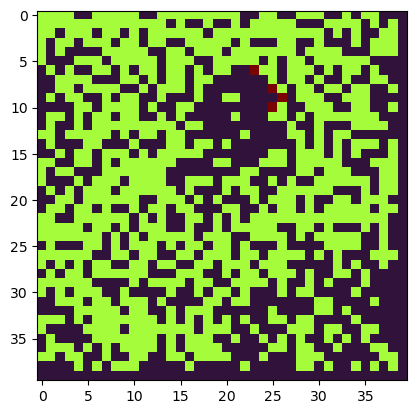

In [6]:
for n in range(0,Nt):
    sleep(0.01) # Sets the maximum animation speed
    plt.imshow(x[:,:,n],cmap='turbo',vmin=0, vmax=2)
    clear_output(wait=True)
    plt.show()

## New Stuff
So far, nothing new, but what if we add a check for accessible fire?
Accessible meaning there is a path (from the edge) to the fire for "firefighters" to put out the fire. This was a lot more complicated to implement that I thought. Special thank you to Ethan for helping debug this mess.

Originally, I was just going to recontextualize how we check if something was on fire:
```py
max([x[i,jl], x[i,jr], x[il,j], x[ir,j]]) == 2
``` 
and change it to:
```py
min([x[i,jl], x[i,jr], x[il,j], x[ir,j]]) == 0
```
to see if there was an open side so firefighters could access the fire, but I decided to go more in depth and take the path all the way out to the edge of the graph, for realism and curiosity sake.


### Adding Water

In [7]:
# check if an index is out of bounds, used in finding paths to fire
def out_of_bounds(i, j, N):
    return i < 0 or i >= N or j < 0 or j >= N
# add assert to see if it works
assert np.isclose(out_of_bounds(-1,10,30),True)
assert np.isclose(out_of_bounds(10,-1,30),True)
assert np.isclose(out_of_bounds(10,100,30),True)
assert np.isclose(out_of_bounds(100,10,30),True)
assert np.isclose(out_of_bounds(10,10,30),False)

# check if the path has finished, or reached the edge
def is_boundary(i,j,N):
    return i == 0 or i == N-1 or j == 0 or j == N-1
# add assert to see if it works
assert np.isclose(is_boundary(0,10,30),True)
assert np.isclose(is_boundary(29,10,30),True)
assert np.isclose(is_boundary(10,29,30),True)
assert np.isclose(is_boundary(22,0,30),True)
assert np.isclose(is_boundary(10,10,30),False)

# this is where the magic happens
#    from a given point, 
#    check in all directions if there is nothing in the way of getting to it, 
#    represented by 0s along the path from a fire (2)
def has_zero_path(matrix, i, j, N):
    #fail case
    if out_of_bounds(i,j,N) or matrix[i,j] != 0:
        return False
    #base case, IE it never hit the fail case
    if is_boundary(i,j,N) and matrix[i,j] == 0:
        return True
    #this prevents it from hanging on certain indices
    matrix[i,j] = -1
    #Recursive call one step out to keep looking
    path_exists = has_zero_path(matrix, i+1, j, N) or \
                  has_zero_path(matrix, i-1, j, N) or \
                  has_zero_path(matrix, i, j+1, N) or \
                  has_zero_path(matrix, i, j-1, N)

    matrix[i,j] = 0
    #return if path exists or not
    return path_exists

#from 3b, used to count number of each and useful for error checking
def counts(x):
    return len(x[x == 0]), len(x[x == 1]), len(x[x == 2]), len(x[x==3])


In [8]:
def forestupdate2(x,p,f,w):
    N = len(x)
    xnew = np.zeros((N,N))
    EMPTY = 0
    TREE = 1
    FIRE = 2
    # add water
    WATER = 3
    
    for i in range(N):
        for j in range(N):
            (il,ir,jl,jr) = nn(i,j,N)
            if x[i,j] == 1:
                if max([x[i,jl], x[i,jr], x[il,j], x[ir,j]]) == 2 or np.random.random() <= f:
                    xnew[i,j] = 2
                else:
                    xnew[i,j] = 1
            elif x[i,j] ==2:
                #had to run the first 4 iterations (steps out) so computationally a pain
                if has_zero_path(x, i+1, j, N) or has_zero_path(x, i-1, j, N) or has_zero_path(x, i, j+1, N) or has_zero_path(x, i, j-1, N):
                    #print(f'Zero path exists: ({i},{j})')
                    if np.random.random()<= w:
                        xnew[i,j] = 3
            elif x[i,j] == 3:
                xnew[i,j] = 0
                
            elif x[i,j] == 0:
                if np.random.rand() <= p:
                    xnew[i,j] = 1
            
    return xnew


In [9]:
#reduce N to see results quicker
N = 20
p = 30/(N**2)
f = 0.15/(N**2)
w = .5 #variable to change, lower = less chance to put out
Nt = 100
x = np.zeros((N,N,Nt))

x[:,:,0] = initialize(N)
            
for n in range(0,Nt-1):
    x[:,:,n+1] = forestupdate2(x[:,:,n],p,f,w)

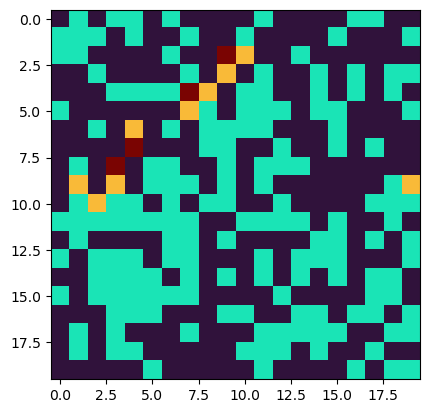

In [10]:
for n in range(0,Nt):
    sleep(.1) # Sets the maximum animation speed
    plt.imshow(x[:,:,n],cmap='turbo',vmin=0, vmax=3)
    clear_output(wait=True)
    plt.show()

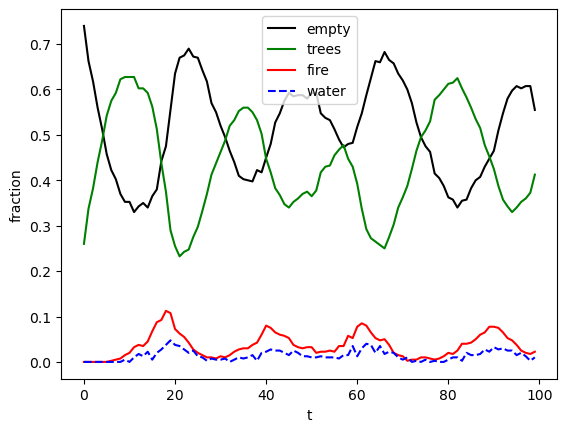

In [11]:
empty = np.zeros(Nt)
trees = np.zeros(Nt)
fire = np.zeros(Nt)
water = np.zeros(Nt)

for i in range(0,Nt):
    empty[i], trees[i], fire[i], water[i] = counts(x[:,:,i])
    
t = np.linspace(0,Nt-1,Nt)    
plt.plot(t,empty/(N**2),'k-')
plt.plot(t,trees/(N**2),'g-')
plt.plot(t,fire/(N**2),'r-')
plt.plot(t,water/(N**2),'b--')
plt.legend(['empty','trees','fire','water'])
plt.xlabel('t')
plt.ylabel('fraction')
plt.show()

### Something Interesting:
My initial assumptions I made, even about this admittedly simple model, were way off. I was way off my predictions about the number of "water" cells and the interactions as a whole. I expected that any sort of "water" added to the mix would help immensely, but It appears not, but more on this later...

### Further Exploration
Originally I was just going to add a burn factor, b, to give fire some probability of staying lit for more than 1 iteration, but again to add more depth I decided against that instead opting for something slightly more complex.

This new addition would be a fire tracking matrix to keep track of what cells have been on fire and for how long. This compounds with the already existing b (now basically used as a normalization factor) to keep cells on fire for longer and more varied lengths of time. 

In [12]:
def forestupdateF(x,p,f,w,b):
    N = len(x)
    xnew = np.zeros((N,N))
    visited = np.zeros((N,N))
    fire = np.zeros((N,N)) #added tracking matrix
    EMPTY = 0
    TREE = 1
    FIRE = 2
    WATER = 3
    
    
    for i in range(N):
        for j in range(N):
            (il,ir,jl,jr) = nn(i,j,N)
            if x[i,j] == 1:
                if max([x[i,jl], x[i,jr], x[il,j], x[ir,j]]) == 2 or np.random.random() <= f:
                    xnew[i,j] = 2
                else:
                    xnew[i,j] = 1
            elif x[i,j] == 2:
                #added checks if cell has reached max burn time
                FireCheck = False
                if fire[i,j] == 2:
                    fire[i,j] = 0
                    xnew[i,j] = 0
                    FireCheck = True
                #if the burn factor is high enough to keep it going and it has not reached its time limit
                if np.random.random()<= b and FireCheck == False:
                    xnew[i,j] = 2
                    fire[i,j] += 1
                #same as before
                if has_zero_path(x, i+1, j, N) or has_zero_path(x, i-1, j, N) or has_zero_path(x, i, j+1, N) or has_zero_path(x, i, j-1, N):
                    #print(f'Zero path exists: ({i},{j})')
                    if np.random.random()<= w:
                        xnew[i,j] = 3
                        fire[i,j] = 0

                    
            elif x[i,j] == 3:
                xnew[i,j] = 0
                
            elif x[i,j] == 0:
                if np.random.rand() <= p:
                    xnew[i,j] = 1
            
    return xnew

In [20]:
N = 20
p = 30/(N**2)
f = 0.15/(N**2)
w = .50
b = .9
Nt = 100
x = np.zeros((N,N,Nt))

x[:,:,0] = initialize(N)
            
for n in range(0,Nt-1):
    x[:,:,n+1] = forestupdateF(x[:,:,n],p,f,w,b)

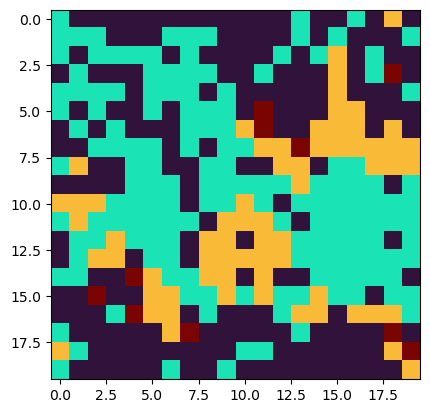

In [21]:
for n in range(0,Nt):
    sleep(.1) # Sets the maximum animation speed
    plt.imshow(x[:,:,n],cmap='turbo',vmin=0, vmax=3)
    clear_output(wait=True)
    plt.show()

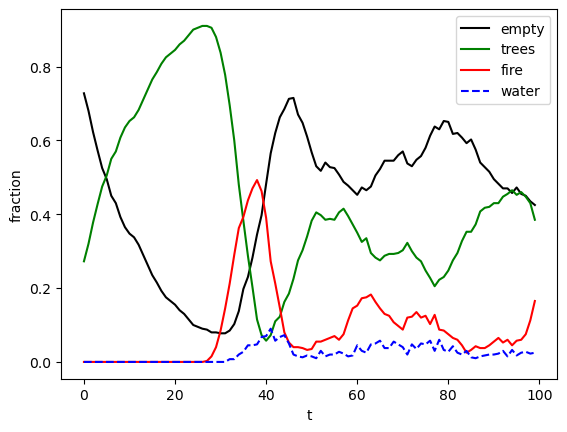

In [22]:
empty = np.zeros(Nt)
trees = np.zeros(Nt)
fire = np.zeros(Nt)
water = np.zeros(Nt)

for i in range(0,Nt):
    empty[i], trees[i], fire[i], water[i] = counts(x[:,:,i])
    
t = np.linspace(0,Nt-1,Nt)    
plt.plot(t,empty/(N**2),'k-')
plt.plot(t,trees/(N**2),'g-')
plt.plot(t,fire/(N**2),'r-')
plt.plot(t,water/(N**2),'b--')
plt.legend(['empty','trees','fire','water'])
plt.xlabel('t')
plt.ylabel('fraction')
plt.show()

# More Interesting:
This graph looks like it almost stabilizes with what are my default parameters (lucky guess after I learned my lesson the first time). So I decided to run it again for longer (more Nt) and see what happens...

In [23]:
N = 20
p = 30/(N**2)
f = 0.15/(N**2)
w = .50
b = .9
Nt = 250
x = np.zeros((N,N,Nt))

x[:,:,0] = initialize(N)
            
for n in range(0,Nt-1):
    x[:,:,n+1] = forestupdateF(x[:,:,n],p,f,w,b)

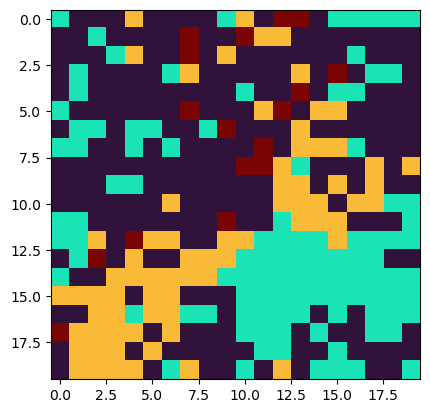

In [25]:
for n in range(0,Nt):
    sleep(.1) # Sets the maximum animation speed
    plt.imshow(x[:,:,n],cmap='turbo',vmin=0, vmax=3)
    clear_output(wait=True)
    plt.show()

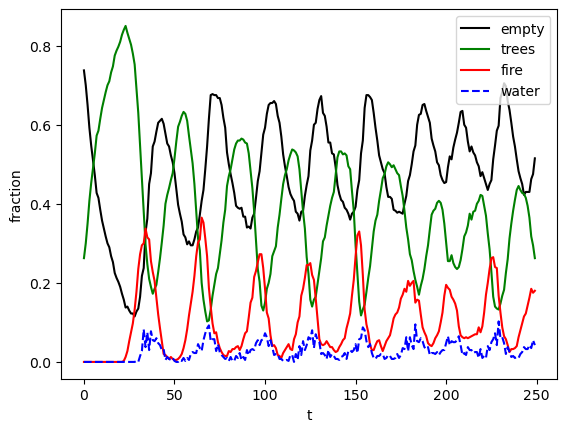

In [26]:
empty = np.zeros(Nt)
trees = np.zeros(Nt)
fire = np.zeros(Nt)
water = np.zeros(Nt)

for i in range(0,Nt):
    empty[i], trees[i], fire[i], water[i] = counts(x[:,:,i])
    
t = np.linspace(0,Nt-1,Nt)    
plt.plot(t,empty/(N**2),'k-')
plt.plot(t,trees/(N**2),'g-')
plt.plot(t,fire/(N**2),'r-')
plt.plot(t,water/(N**2),'b--')
plt.legend(['empty','trees','fire','water'])
plt.xlabel('t')
plt.ylabel('fraction')
plt.show()

# More Interesting:
This seems to almost have a periodic behavior, with a large swing to fire and then several smaller fires follow as the firefighters "clean up" before the next big forest fire. This seems like it could be representative of some real life fires. There are probably too many factors and randomness going into my specific model, but With more time/refinement/expertise, this could be useful.

This also looks great and was in no way expected or intended. I would be interested to solve this system to see what the steady state actually is, and/or if this is it? 

There is an element of randomness to this obviously, but the consistency of peaks and valleys crossing (red and green) and then steadying out for a while to only do it again certainly peaked my interest.

## Accuracy
Obviously, no direct 1:1 correlation in the real world, but could be used to see how different response times, how effective different responses are (w factor), and this model can even account for faster or slower burning fires to some extent (using b).
In a logical sense, the increase in trees leads to an increase in fires which leads to an increase in firefighting paths for the fires, all demonstrated by the graphs and simulations. There are no overtakes or weird behaviors, like hanging fires, so the model works as intended with a reasonable level of certainty.

All functions work as intended and all passed all tests. Through about 4 hours of debugging and testing (thanks again ethan), can demonstrate that the pathing algorithm works as intended. As for everything else. I tried my best to gauge the correct parameters to make one portion (fire, trees, water) not too dominant so the simulation dies after a few run throughs.

Related, The size of the matrix (forest) directly affects the performance and number of paths available. This is because the boundaries of the matrix is the goal of the pathing function, so  if one uses a bigger matrix, there are more possible end points (and more possibilities in general).

## Reflection
Honestly I got way more into this than I expected to. My original idea was to basically mess with this system with a few tweaks and see if it came out with anything interesting. Instead, I think I ended up building interesting into this model, through much more advanced algorithms (pathing) and logic (fire matrix). This did add a lot of overhead, but the increase in wait times between runs was well worth it for the enhanced model. I actually had a lot of fun (minus the debugging) making, testing, and playing around in this model. Most of what I added was on the backend, like path algorithm, leaving a lot of room for experimentation in the front end, like how effective is the water. Basically, I feel like I made a much better sandbox to start playing in, not that I necessarily made the best sandcastle.